# **Convolutional Neural Networks (CNN)**

## **Residual Networks (RasNet)**

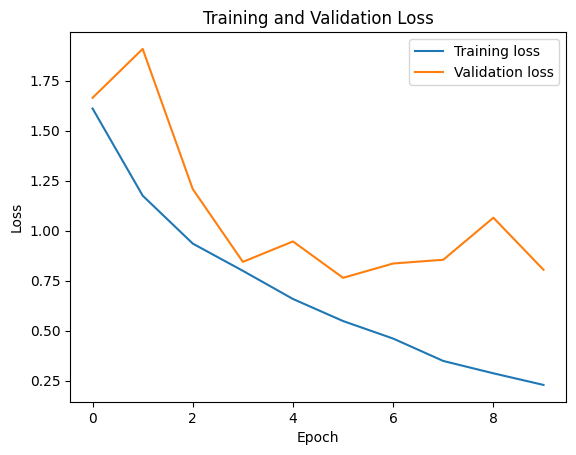

1563/1563 [==============================] - 880s 563ms/step - loss: 0.2290 - accuracy: 0.9215 - val_loss: 0.8048 - val_accuracy: 0.7650


In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from IPython.display import clear_output
from tensorflow.keras.callbacks import LambdaCallback
class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.epochs = 0
        self.figure = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.epochs += 1
        
        clear_output(wait=True)
        plt.plot([log['loss'] for log in self.logs], label='Training loss')
        plt.plot([log['val_loss'] for log in self.logs], label='Validation loss')
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.show()


# Define the residual block
def residual_block(x, filters, kernel_size=3, stride=1):
    # Shortcut
    shortcut = x
    
    # First convolution layer
    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    # Second convolution layer
    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)  # Stride is now 1
    x = BatchNormalization()(x)
    
    # Adjusting the shortcut dimensions if necessary
    if x.shape != shortcut.shape:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)  # Stride is applied here
        shortcut = BatchNormalization()(shortcut)
    
    # Adding the shortcut to the output
    x = Add()([x, shortcut])
    x = ReLU()(x)
    
    return x

# Define the ResNet-18 model
def resnet18():
    input = Input(shape=(32, 32, 3))
    x = Conv2D(64, (7, 7), padding='same', strides=2)(input)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    for _ in range(2):
        x = residual_block(x, 64)
    for _ in range(2):
        x = residual_block(x, 128, stride=2)
    for _ in range(2):
        x = residual_block(x, 256, stride=2)
    for _ in range(2):
        x = residual_block(x, 512, stride=2)
    x = GlobalAveragePooling2D()(x)
    output = Dense(10, activation='softmax')(x)
    model = Model(inputs=input, outputs=output)
    return model


# Build the model
model = resnet18()

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Load CIFAR-10 data
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0  # Normalize pixel values to be between 0 and 1

# Early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)
plot_losses = PlotLosses()

def on_epoch_end(epoch, logs):
    print(f"Epoch {epoch+1}, Accuracy: {logs['accuracy']:.4f}, Validation Accuracy: {logs['val_accuracy']:.4f}")


print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
# history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))
# Train the model with the callbacks
history = model.fit(
    train_images, 
    train_labels, 
    epochs=10,
    validation_data=(test_images, test_labels),
    callbacks=[plot_losses, early_stopping, model_checkpoint]
)


# **Obtain predictions**

In [13]:
import numpy as np


# Get the model's predictions
predictions = model.predict(test_images)

# Get the class with the highest probability for each sample
y_pred = np.argmax(predictions, axis=1)

# Flatten y_true
y_true = test_labels.flatten()


313/313 [==============================] - 15s 46ms/step


# **Visualization**

## **Confusion Matrix**

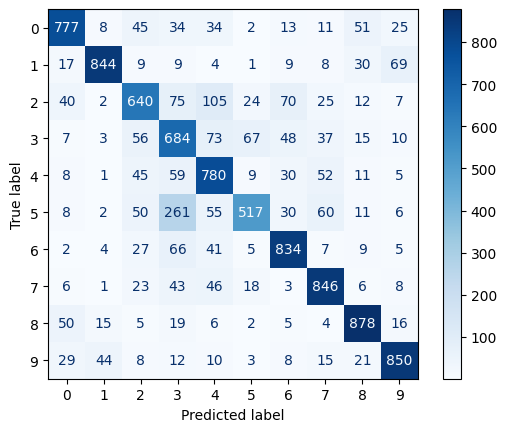

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=np.arange(10))

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(10)])
disp.plot(cmap=plt.cm.Blues)
plt.show()


## **ROC_Curve**

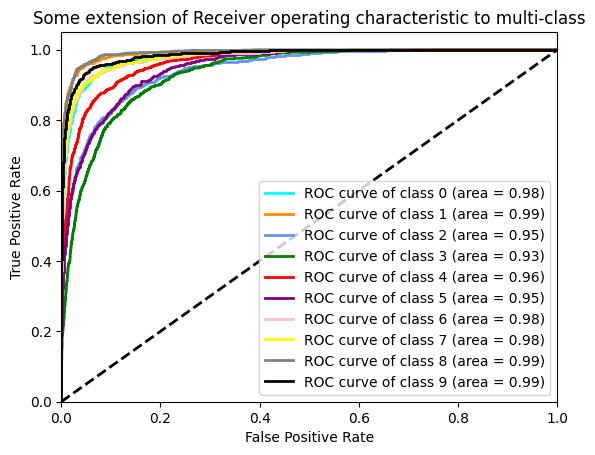

In [15]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the labels
y_bin_true = label_binarize(y_true, classes=np.arange(10))
n_classes = y_bin_true.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin_true[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'pink', 'yellow', 'grey', 'black'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()
